In [ ]:
import numpy as np
import sympy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: agg


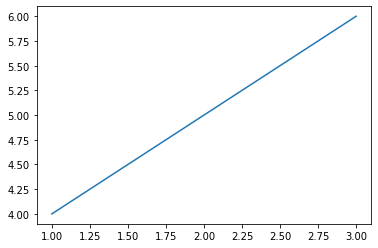

In [ ]:
x = [1, 2, 3]
y = [4, 5, 6]
plt.plot(x, y)
plt.show()

In [ ]:
def definition_to_function(s):
    lhs, rhs = s.split("=", 1)
    params = sympy.sympify(lhs).args
    f = sympy.sympify(rhs)
    f_int = sympy.integrate(f, params)
    print(f'The integrated function is {f_int}')
    def func(*arguments):
        argdict = dict(zip(params, arguments))
        result = f.subs(argdict)
        return float(result)
    def func_int(*arguments):
        argdict = dict(zip(params, arguments))
        result = f_int.subs(argdict)
        return float(result)

    return func, rhs, func_int, f_int

In [ ]:
def input_func():
    func, func_str, func_integrate, f_int_str = definition_to_function(input("Please enter the formula:"))
    a = int(input("Please enter the lower bound of integration:"))
    b = int(input("Please enter the upper bound of integration:"))
    n = int(input("Please enter the number of intervals / panels that you want:"))
    return func, func_str, func_integrate, f_int_str, a, b, n

In [ ]:
def function_true(f, a, b):
    interval = b-a
    XTrue = np.linspace(a-interval/2, b+interval/2, num=1000)
    funcResTrue = np.array([f(x) for x in XTrue])
    return XTrue, funcResTrue

def results(area, true_area):
    print(f'the approximate area under the curve is {area}')
    print(f'the true area under the curve is {true_area}')
    print(f'the difference in measurement is {area-true_area}')
    print(f'the relative true error is {abs((true_area-area)/true_area) * 100}%')

In [ ]:
def static_plot_riemann(riemann, title, m=1, alignment='center'):
    func, func_str, func_integrate, f_int_str, a, b, n = input_func()
    area, x, x_pos, y_pos = riemann(func, a, b, n)
    true_area = func_integrate(b) - func_integrate(a)
    x_true, y_true = function_true(func, a, b)
    title += ' of f(x) = ' + func_str + f', n = {n}, ' + f'from a = {a} to b = {b}'
    fig = plt.figure(figsize=(12, 5)); plt.clf();
    ax = fig.add_subplot(1,1,1)
    plot_engine_riemann(ax, title, x_true, y_true, x_pos, y_pos, x,
                        x[::n//5 if n//5 != 0 else 1], m*(b-a) / n, alignment)
    return area, true_area

In [ ]:
def plot_engine_riemann(ax, title, XTrue, funcResTrue, X, funcResults,
                        Xminor, Xmajor, h, alignment='center'):
    ax.bar(X, funcResults, width=h, alpha=0.2,
           align=alignment, label="approximation")
    ax.plot(XTrue, funcResTrue, label="true")
    ax.plot(X, funcResults, "b.", markersize=3)
    plt.legend()
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y = f(X)')
    ax.set_xticks(Xmajor)
    ax.set_xticks(Xminor, minor=True)
    ax.grid(which='minor', alpha=0.3)
    ax.grid(which='major', alpha=1.0)

Please enter the formula:f(x) = x**2
The integrated function is x**3/3
Please enter the lower bound of integration:5
Please enter the upper bound of integration:8
Please enter the number of intervals / panels that you want:8
the approximate area under the curve is 121.7578125
the true area under the curve is 129.0
the difference in measurement is -7.2421875
the relative true error is 5.614098837209303%


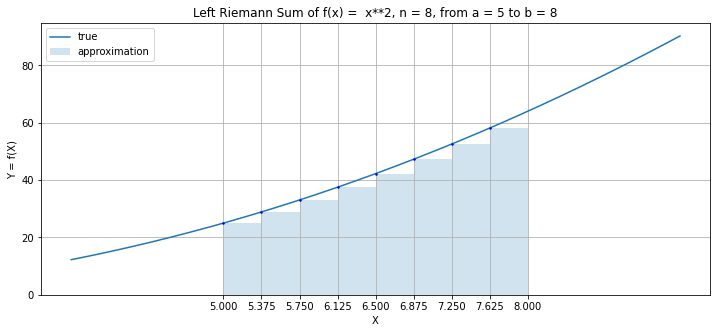

In [ ]:
def riemann_left(f, a, b, n):
    if n == 0:
        return
    x = np.linspace(a, b, num=n+1)
    x_left = x[:-1]
    y_left = np.array([f(c) for c in x_left])
    total = np.sum(y_left) * (b-a) / n
    return total, x, x_left, y_left

results(*static_plot_riemann(riemann_left, "Left Riemann Sum", alignment='edge'))

Please enter the formula:f(x) = x**2
The integrated function is x**3/3
Please enter the lower bound of integration:5
Please enter the upper bound of integration:8
Please enter the number of intervals / panels that you want:8
the approximate area under the curve is 128.96484375
the true area under the curve is 129.0
the difference in measurement is -0.03515625
the relative true error is 0.027252906976744186%


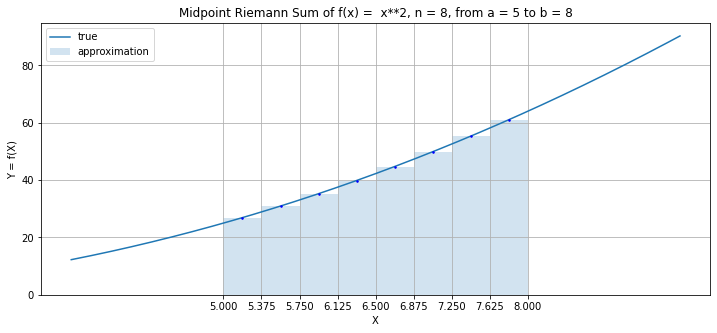

In [ ]:
def riemann_mid(f, a, b, n):
    if n == 0:
        return
    x = np.linspace(a, b, num=n+1)
    x_mid = (x[:-1] + x[1:]) / 2
    y_mid = np.array([f(c) for c in x_mid])
    total = np.sum(y_mid) * (b-a) / n
    return total, x, x_mid, y_mid

results(*static_plot_riemann(riemann_mid, "Midpoint Riemann Sum"))

In [ ]:
def riemann_right(f, a, b, n):
    if n == 0:
        return
    x = np.linspace(a, b, num=n+1)
    x_right = x[1::]
    y_right = np.array([f(c) for c in x_right])
    total = np.sum(y_right) * (b-a) / n
    return total, x, x_right, y_right

results(*static_plot_riemann(riemann_right, "Right Riemann Sum", -1, 'edge'))

Please enter the formula:f(x) = x**3
The integrated function is x**4/4
Please enter the lower bound of integration:5
Please enter the upper bound of integration:8
Please enter the number of intervals / panels that you want:6
the approximate area under the curve is 966.9375
the true area under the curve is 867.75
the difference in measurement is 99.1875
the relative true error is 11.430423509075194%


In [ ]:
def plot_engine(ax, title, XTrue, funcResTrue,
                X, funcResults, Xminor, Xmajor):
    ax.plot(X, funcResults, label="approximation")
    ax.plot(XTrue, funcResTrue, label="true")
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y = f(X)")
    ax.set_xticks(Xmajor)
    ax.set_xticks(Xminor, minor=True)
    ax.grid(which='minor', alpha=0.3)
    ax.grid(which='major', alpha=1.0)
    ax.fill_between(X, funcResults)
    ax.legend()

In [ ]:
def trapezoid(f, a, b, n):
    if n == 0:
        return
    X = np.linspace(a, b, num=n+1)
    function_results = np.array([f(x) for x in X])
    weights = np.full((n+1,), 2)
    weights[0] = 1
    weights[-1] = 1
    h = (b-a) / n
    total = np.sum(weights * function_results)
    total *= (b-a)/(2*n)
    return total, X, function_results


Please enter the formula:f(x) = x**2
The integrated function is x**3/3
Please enter the lower bound of integration:2
Please enter the upper bound of integration:100
Please enter the number of intervals / panels that you want:5
the approximate area under the curve is 339605.2800000001
the true area under the curve is 333330.6666666666
the difference in measurement is 6274.613333333458
the relative true error is 1.8823990591925113%


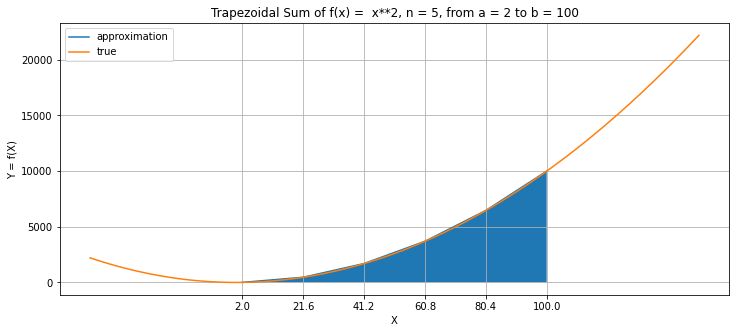

In [ ]:
def static_plot(num_int, title, mult=1):
    func, func_str, func_integrate, f_int_str, a, b, n = input_func()
    area, X, function_results = num_int(func, a, b, n)
    XTrue, funcResTrue = function_true(func, a, b)
    title += f" of f(x) = {func_str}, n = {n}, from a = {a} to b = {b}"
    fig = plt.figure(figsize=(12, 5)); fig.clf();
    ax = fig.add_subplot(1,1,1)
    XMajor = X[::mult*(n//5 if n//5 != 0 else 1)]
    if mult != 1:
        XMajor = np.concatenate((XMajor, np.array([X[-1]])))
#     plot_engine(ax, title, XTrue, funcResTrue, X, function_results,
#                 X[::mult], X[::mult*(n//5 if n//5 != 0 else 1)])
    plot_engine(ax, title, XTrue, funcResTrue, X, function_results,
                X[::mult], XMajor)
#     np.concatenate((interpolation_X[::10], np.array([interpolation_X[-1]]))
    true_area = func_integrate(b) - func_integrate(a)
    return area, true_area

results(*static_plot(trapezoid, "Trapezoidal Sum"))

Please enter the formula:f(x) = x**2
The integrated function is x**3/3
Please enter the lower bound of integration:2
Please enter the upper bound of integration:100
Please enter the number of intervals / panels that you want:5


AttributeError: ignored

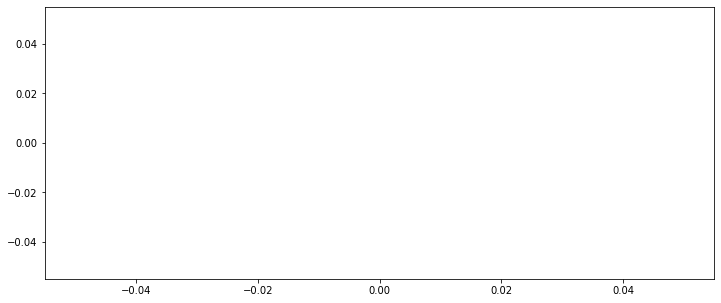

In [ ]:
func, func_str, func_integrate, f_int_str, a, b, n = input_func()
interval = b-a

title = f"Trapezoidal Sum of f(x) = {func_str}, n = {n}, from a = {a} to b = {b}"

fig = plt.figure(figsize=(12, 5)); plt.clf();
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot([], [], lw=2)
x_ticks = ax.get_xticks()

def init():
    ax.set_ylabel("Y = f(X)")
    ax.set_xlabel("X")
    ax.set_xlim(a-interval, b+interval)
    ax.set_xticks(np.array([]))
    line.set_data([], [])
    return line,

def animate_trapezoid(i):
    plt.cla()
    area, X, function_results = trapezoid(func, a, b, i+1)
    XTrue, funcResTrue = function_true(func, a, b)
    plot_engine(ax, title, XTrue, funcResTrue,
                X, function_results, X,
                X[::n//5 if n//5 != 0 else 1])
anim = mpl.animation.FuncAnimation(fig, animate_trapezoid, init_func=init, frames=n-1, interval=500)

In [ ]:
def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3);
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom;
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom;
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom;
    return A,B,C

def simpson_util(X1, X2, X3, Y1, Y2, Y3):
    interpolation_X = np.array([])
    interpolation_Y = np.array([])
    for x1, x2, x3, y1, y2, y3 in zip(X1, X2, X3, Y1, Y2, Y3):
        A, B, C = calc_parabola_vertex(x1, y1, x2, y2, x3, y3)
        par_func = lambda A, B, C, a: A*(a**2)+B*a+C
        int_X = np.linspace(x1, x3, 10)
        int_Y = par_func(A, B, C, int_X)
        interpolation_X = np.concatenate((interpolation_X, int_X))
        interpolation_Y = np.concatenate((interpolation_Y, int_Y))
    return interpolation_X, interpolation_Y

In [ ]:
def simpson(f,a, b, n):
    X = np.linspace(a, b, num=n+1)
    Y = np.array([f(x) for x in X])

    X1 = np.array(X[0::2])
    X2 = np.array(X[1::2])
    X3 = np.array(X[2::2])
    Y1 = np.array(Y[0::2])
    Y2 = np.array(Y[1::2])
    Y3 = np.array(Y[2::2])
    interpolation_X, interpolation_Y = simpson_util(X1, X2, X3, Y1, Y2, Y3)

    weights = np.full((n+1,), 1)
    h = (b-a) / n
    weights[1::2] = 4
    weights[2::2] = 2
    weights[-1] = 1
    total = np.sum(weights * Y)
    total *= h / 3
    return total, interpolation_X, interpolation_Y



In [ ]:
results(*static_plot(simpson, "Simpson Sum", 10))

Please enter the formula:f(x) = x**4
The integrated function is x**5/5
Please enter the lower bound of integration:3
Please enter the upper bound of integration:8
Please enter the number of intervals / panels that you want:4
the approximate area under the curve is 6506.627604166667
the true area under the curve is 6505.0
the difference in measurement is 1.6276041666669698
the relative true error is 0.025020817320014908%


In [ ]:
func, func_str, func_integrate, f_int_str, a, b, n = input_func()
interval = b-a
title = f"Trapezoidal Sum of f(x) = {func_str}, n = {n}, from a = {a} to b = {b}"

fig = plt.figure(figsize=(12, 5))
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))

def init():
    ax.set_ylabel("f(X)")
    ax.set_xlabel("X")
    ax.set_xlim(a-interval, b+interval)
    ax.set_ylim(1, -1)
    ax.set_xticks(np.array([]))
    line.set_data([], [])
    return line,
def animate_simpson(i):
    plt.cla()
    area, X, function_results = simpson(func, a, b, 2*(i+1))
    XTrue, funcResTrue = function_true(func, a, b)
    plot_engine(ax, title, XTrue, funcResTrue,
                X, function_results, X[::10],
                X[::10*(i//5 if i//5 != 0 else 1)])

anim = mpl.animation.FuncAnimation(fig, animate_simpson, init_func=init, frames=n, interval=1000)

Please enter the formula:f(x) = x**3
The integrated function is x**4/4
Please enter the lower bound of integration:4
Please enter the upper bound of integration:8
Please enter the number of intervals / panels that you want:10


AttributeError: ignored